# Set things up

In [1]:
import os
import pandas as pd
import datetime
from sklearn.model_selection import StratifiedShuffleSplit

DATA_SOURCE = "C:/Users/sbranchett/Data/WiFi_data"
ACCESS_POINT = os.path.join(DATA_SOURCE, "test1000.csv")

uni_hols = (datetime.date(year=2021, month=5, day=5),
            datetime.date(year=2021, month=5, day=13),
            datetime.date(year=2021, month=5, day=14),
            datetime.date(year=2021, month=5, day=24)
           )  # National Holidays and Collective Free days

def rooster(date):
    # categorise the days of the academic year at TU Delft between 1 May 2021 and 29 August 2021
    
    if (date > datetime.date(year=2021, month=5, day=16)) and \
       (date < datetime.date(year=2021, month=5, day=22)):
        categorie = "Exam_BSc"
    elif (date > datetime.date(year=2021, month=6, day=15)) and \
         (date < datetime.date(year=2021, month=6, day=19)):
        categorie = "Study_mixed"
    elif (date > datetime.date(year=2021, month=6, day=22)) and \
         (date < datetime.date(year=2021, month=6, day=26)):
        categorie = "Exam_mixed"
    elif (date > datetime.date(year=2021, month=6, day=29)) and \
         (date < datetime.date(year=2021, month=7, day=3)):
        categorie = "Exam"
    elif (date > datetime.date(year=2021, month=8, day=8)) and \
         (date < datetime.date(year=2021, month=8, day=14)):
        categorie = "Exam"
    elif (date > datetime.date(year=2021, month=7, day=4)):
        categorie = "Free"
    else:
        categorie = "Learn"
    return categorie

# Get the interesting fields from the WiFi data

In [2]:
def load_wifi_data(interesting_columns, path=ACCESS_POINT):
    raw_data = pd.read_csv(path, delimiter=",")
    raw_data = raw_data.rename(columns=lambda x: x.strip())
    return raw_data[interesting_columns]

interesting_columns = ["timestamp", "clientCount", "locationHierarchy"]
all_data = load_wifi_data(interesting_columns)

# Extract Building

In [3]:
all_data["building"] = all_data["locationHierarchy"].str.split(" > ",expand=True)[1]

# Create five minute time buckets

In [4]:
# convert timestamp, given as Epoch in milliseconds, to datetime
all_data["datetime"] = all_data["timestamp"].apply(lambda d: datetime.datetime.fromtimestamp(int(d/1000)))

# separate out the date and the hour
all_data["date"] = all_data["datetime"].apply(lambda d: datetime.datetime.date(d))
all_data["time_5mins"] = all_data["datetime"].apply(lambda d: datetime.time(d.hour, 5*int(d.minute/5), 0))

# create buckets of 5 minutes
all_data["bucket_5mins"] = all_data.apply(lambda row: datetime.datetime.combine(row["date"], row["time_5mins"]), axis=1)

# Bucketise clientCounts in five minute intervals, total per building and total on campus
Add up clientCounts for building / hour_bucket pair

In [5]:
all_data["time_building"] = all_data.apply(lambda row: str(row["bucket_5mins"]) + " _ " + str(row["building"]), axis=1)

bucket_data = all_data.groupby("time_building").sum().drop(columns=["timestamp"])

print(bucket_data)

                                                    clientCount
time_building                                                  
2021-05-14 13:30:00 _ 20-Aula                                15
2021-05-14 13:30:00 _ 21-BTUD                                65
2021-05-14 13:30:00 _ 26-Bouwcampus                          22
2021-05-14 13:30:00 _ 30-IKC_ISD-FMVG                        46
2021-05-14 13:30:00 _ 30-O S                                  1
2021-05-14 13:30:00 _ 31-TBM                                  0
2021-05-14 13:30:00 _ 32-OCP-IO                              10
2021-05-14 13:30:00 _ 34-3ME                                 32
2021-05-14 13:30:00 _ 35-Drebbelweg                           1
2021-05-14 13:30:00 _ 36-EWI LB_K t/m 3 & HB_K ...            1
2021-05-14 13:30:00 _ 36-EWI-HB                               0
2021-05-14 13:30:00 _ 38-Cultureel Centrum                    3
2021-05-14 13:30:00 _ 45-LSL                                  0
2021-05-14 13:30:00 _ 58-TNW-Zuid       

# Create Work days and Student days

In [6]:
all_data["weekday"] = all_data.apply(lambda row: row["date"].weekday() < 5, axis=1)
all_data["uni_hols"] = all_data.apply(lambda row: row["date"].weekday() in uni_hols, axis=1)
all_data["academic_yr"] = all_data.apply(lambda row: rooster(row["date"]), axis=1)

# Separate Test Set stratified over buildings

In [7]:
# get rid of rows with missing data
all_data = all_data.dropna()

# split has to have at least 2 rows with the same value
buildings = all_data["building"].value_counts()
to_drop = []
for index in buildings.index:
    if buildings[index] < 2:
        to_drop.append(index)
all_data = all_data[~all_data["building"].isin(to_drop)]

# indices need to be consecutive for split
all_data.index = range(len(all_data))

In [8]:
# check all went well
print('to_drop',to_drop)
print(all_data["building"].value_counts())

to_drop ['45-LSL', 'VLL-LAB(TNO)']
34-3ME                               216
58-TNW-Zuid                          153
32-OCP-IO                            134
21-BTUD                               84
62-LR                                 70
20-Aula                               66
26-Bouwcampus                         61
35-Drebbelweg                         37
30-IKC_ISD-FMVG                       30
66-Fellowship                         29
38-Cultureel Centrum                  22
31-TBM                                22
61-Vliegtuighal                       17
30-O S                                17
36-EWI-HB                             16
36-EWI LB_K t/m 3 & HB_K  t/m 2e      10
60-LMS                                 7
63-Simona                              5
Name: building, dtype: int64


In [9]:
all_data.shape

(996, 12)

<AxesSubplot:>

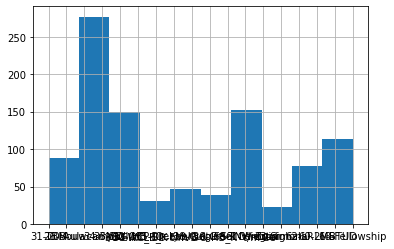

In [10]:
all_data["building"].hist()

In [11]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(all_data, all_data["building"]):
    strat_train_set = all_data.loc[train_index]
    strat_test_set = all_data.loc[test_index]

print(strat_train_set)

         timestamp  clientCount  \
242  1620991804503            0   
327  1620991804522            0   
507  1620991804561            0   
880  1620991804643            0   
611  1620991804584            0   
..             ...          ...   
714  1620991804608            0   
524  1620991804565            0   
212  1620991804497            0   
287  1620991804513            0   
817  1620991804630            0   

                                     locationHierarchy              building  \
242               TUDelft > 32-OCP-IO > 1e Verdieping              32-OCP-IO   
327                  TUDelft > 34-3ME > 4e Verdieping                 34-3ME   
507                    TUDelft > 34-3ME > Beganegrond                 34-3ME   
880                     TUDelft > 62-LR > Beganegrond                  62-LR   
611   System Campus > 38-Cultureel Centrum > 2e Ver...  38-Cultureel Centrum   
..                                                 ...                   ...   
714             TUD

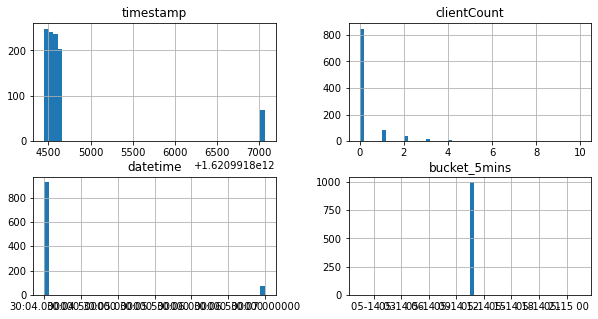

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
all_data.hist(bins=50, figsize=(10,5))
plt.show()